In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import dill as pickle
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [17]:
raw_training_data = pd.read_csv("../input_data/train.csv")
raw_testing_data = pd.read_csv("../input_data/test.csv")
print("raw_training_data shape: ",raw_training_data.shape)
print("raw_testing_data shape: ",raw_testing_data.shape)

labels_ = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']
y_train = raw_training_data[labels_]

raw_training_data shape:  (20972, 9)
raw_testing_data shape:  (8989, 3)


In [18]:
raw_training_data.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [15]:
raw_training_data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0


# EDA

#### Cheacking missing values

In [4]:
raw_training_data.isnull().sum()

ID          0
TITLE       0
ABSTRACT    0
Topic 1     0
Topic 2     0
Topic 3     0
Topic 4     0
Topic 5     0
Topic 6     0
dtype: int64

In [5]:
raw_testing_data.isnull().sum()

ID             0
TITLE          0
ABSTRACT       0
Topic 1     2972
Topic 2     2972
Topic 3     2972
Topic 4     2972
Topic 5     2972
Topic 6     2972
dtype: int64

We have all unique titles

In [6]:
topics = raw_training_data[labels_]

<AxesSubplot:>

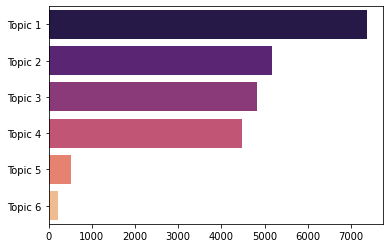

In [7]:
topic_wise_count= topics.sum(axis=0)
sns.barplot(y=topic_wise_count.index, x=topic_wise_count, orient='h', palette='magma')

**Here we have inbalanced dataset. This can hurt out training process if not taken care.  
We will try to check without balancing it and then if needed with the classweights.**

<AxesSubplot:ylabel='num_of_topics'>

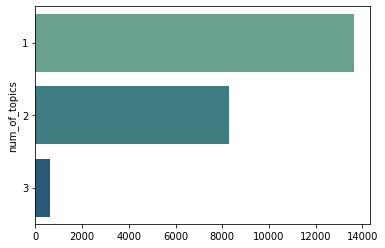

In [8]:
sum_of_topis = pd.DataFrame(topics.sum(axis=1),columns=['num_of_topics']).groupby('num_of_topics').apply(sum).num_of_topics
sns.barplot(y=sum_of_topis.index, x=sum_of_topis.values, orient='h', palette='crest')

This is multi class classification problem. But one paper can have multiple topics.  

**Approach 1**
We can treat all the topics separately. Use probablity score of model and decide multiple categories.

**Approach 2**
We can consider all 6 topics as binary number and convert it into decimal number.  
At the end we can again convert the decimal number to binary and get the multiple topics.  

We can simply use the multilabel classification with 1st approach

# Cleaning

In [9]:
def clean_transform_title_abstract(dataframe, title_vectorizer, abstarct_vectorizer):
    '''
    Takes dataframe, title TFIDF vectorizer and abstract vectorizer as input.
    Returns tfidf vectorized title and abstract columns.
    '''
#     def text_clean(text):
#         pattern = r'[^a-zA-Z0-9\s]'
#         return re.sub(pattern,'',text)
    def text_clean(text):
        snowball_stemmer = SnowballStemmer("english")
        pattern = r'[^a-zA-Z0-9\s]'
        cleaned_sent = re.sub(pattern,'',text)
        word_tokens = cleaned_sent.split()
        word_tokens_stemmed = [snowball_stemmer.stem(w) for w in word_tokens if w not in stop_words]
        return ' '.join(word_tokens_stemmed)
    
    title_col = dataframe.TITLE
    cleaned_abstarct_col = dataframe.ABSTRACT.map(text_clean)
    
    title_col_tfidf = title_vectorizer.fit_transform(title_col)
    abstract_col_tfidf = abstarct_vectorizer.fit_transform(cleaned_abstarct_col)
    return title_col_tfidf, abstract_col_tfidf

In [10]:
title_tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
abstract_tf_idf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

title_col_vec, abstract_col_vec = clean_transform_title_abstract(raw_training_data, 
                                                                 title_tf_idf_vectorizer, 
                                                                 abstract_tf_idf_vectorizer)
print(title_col_vec.shape)
print(abstract_col_vec.shape)

(18000, 1000)
(18000, 5000)


**Saving the tfidf vectorizer for title and abstract for future use.
We will use these to vectorize test data**

In [11]:
pickle.dump(title_tf_idf_vectorizer, open('../output_files/title_tfidf_vectorizer_6000f.sav', 'wb'))
pickle.dump(abstract_tf_idf_vectorizer, open('../output_files/abstract_tfidf_vectorizer_6000f.sav', 'wb'))

In [12]:
title_features = pd.DataFrame(title_col_vec.todense(), columns=title_tf_idf_vectorizer.vocabulary_)
abstract_features = pd.DataFrame(abstract_col_vec.todense(), columns=abstract_tf_idf_vectorizer.vocabulary_)
X_train_data = pd.concat([title_features, abstract_features], axis=1)
X_train_data.shape

(18000, 6000)

**Saving the transformed train data**

In [13]:
X_train_data.to_csv('../output_files/train_tfidf_6000f.csv', index=False)

KeyboardInterrupt: 